In [21]:
import numpy as np
import xarray as xr

from eval_utilities import spatial_temporal_metrics as stm
from eval_utilities import visualization as vis
import matplotlib.pyplot as plt

import pandas as pd

import os
import glob

In [22]:
import yaml
with open(f"config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
# load the predicted variables
variables = CONFIG["targets_prog"] + CONFIG["targets_diag"]


In [23]:
# load all the ensemble members and collect into 
# load ensembles name in a list
# prepare the numpy ensemble array
import dask.array as da

def find_files_with_name(directory, filename):
    # Create a pattern for glob
    pattern = os.path.join(directory, f'*{filename}*')
    
    # Use glob to find all files matching the pattern
    matching_files = glob.glob(pattern)
    
    return matching_files

# Example usage
directory_path = '/data/ch23/data_ch23/unimp_ens'  # Replace with your folder path
file_name = 'unimp'  # File name to search for
files_list = find_files_with_name(directory_path, file_name)

# preprocess .zarr to da.array
ens_file_list=[]
for i,ens_file in enumerate(files_list):

    ens1=xr.open_zarr(ens_file)
    desired_chunks = (4, 10051, 17)  # Adjust based on your desired chunk sizes
    ens1 = ens1.chunk({'time': 4, 'x': 10051, 'variable': 17})
    ens1_array=ens1.data
    ens_file_list.append(ens1_array)

stacked_ens = da.stack(ens_file_list)
y_pred=stacked_ens

In [24]:
# load groundtruth
v1=xr.open_zarr("/data/ch23/data_ch23/unimp_ens/euro_unimp_1_train_2010_2019_val_2020_2020.zarr")

train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2020", "2022"),variable=variables)  
# select the same variable list as prediction
y_true=train_ds.data # make sure y_true is dask

### visualize the ensemble at one grid point for one variable

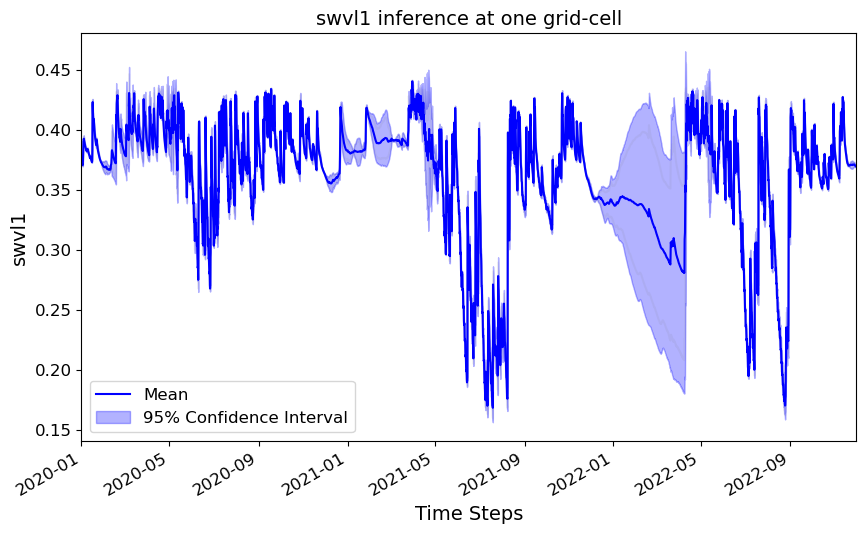

In [16]:
# choose one grid point and one variable, showing the time series -- probably one part of the time series
# only for one grid point
# customize the grid points and the variables -- randomly choose point 1000
# maybe not necessary to use dask here for plotting the ensemble
# 0 is the first variable swvl

data=y_pred[:2,:,1000,0] 
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
confidence_interval = 1.96 * std / np.sqrt(data.shape[0])
# Generate datetime index
date_range = pd.date_range(start='2020-01-01 00:00:00', end='2022-11-30 18:00:00', periods=4260)
# Plotting
plt.figure(figsize=(10, 6))

# Plot each realization
#for i in range(data.shape[0]):
#    plt.plot(date_range,data[i], color='gray', alpha=0.1)

# Plot the mean time series
plt.plot(date_range,mean, color='blue', label='Mean')

# Shade the confidence interval
plt.fill_between(date_range, mean - confidence_interval, mean + confidence_interval, color='blue', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('swvl1', fontsize=14)
plt.title('swvl1 inference at one grid-cell', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(pd.Timestamp('2020-01-01 00:00:00'), pd.Timestamp('2022-11-30 18:00:00'))
plt.gcf().autofmt_xdate()
plt.show()

In [25]:
# calculating the ensemble crps using dask
def dask_sort_along_axis(arr, axis=0):
    """
    Sort a Dask array along a specified axis using a custom function.
    """
    return da.map_blocks(lambda x: np.sort(x, axis=axis), arr, dtype=arr.dtype)


def crps_dask(y_true, y_pred, time=True, sample_weight=None, norm=False):
    """
    Calculate Continuous Ranked Probability Score -- CRPS is measured in the same units as the variable
    Data based on size (time, lat*lon, vars) where N=number of samples (in time) and each grid point will have one value
    Args:
        y_true (np.array): Ground truth with shape (time, lat*lon, vars).
        y_pred (np.array): Predicted values from n_seeds ensembles with shape (n_seeds, time, lat*lon, vars).
        sample_weight (np.array, optional): Sample weights.
        norm (bool, optional): Flag to normalize the CRPS scores.
    
    Returns:
        np.array: CRPS score for each height profile (lat*lon, vars).Returns:
        
    modified based on@https://github.com/lm2612/WaveNet_UQ/
    """
    # Number of ensemble predictions
    num_samples = y_pred.shape[0]
    
    # Sort predictions along the ensemble axis
    #y_pred = da.sort(y_pred, axis=0)

    y_pred = dask_sort_along_axis(y_pred, axis=0)
    
    # Calculate differences between consecutive sorted predictions
    diff = y_pred[1:] - y_pred[:-1]
    
    # Calculate weights for CRPS calculation
    weight = da.arange(1, num_samples) * da.arange(num_samples - 1, 0, -1)
    #weight = weight[:, da.newaxis, da.newaxis, da.newaxis]
    weight = da.asarray(weight[:, None, None, None])
    weight = weight.rechunk((weight.shape[0], 1, 1, 1))
    # Calculate the absolute error
    y_true_expanded = y_true.expand_dims(dim="ensemble", axis=0)

    # Convert to Dask array if necessary
    y_true_dask = y_true_expanded.data

    #absolute_error = da.mean(da.abs(y_pred - da.expand_dims(y_true, 0)), axis=0)
    absolute_error = da.mean(da.abs(y_pred - y_true_dask), axis=0)
    
    # Calculate per observation CRPS

    per_obs_crps = absolute_error - da.sum(diff * weight, axis=0) / num_samples**2

    if time==False:
        return per_obs_crps

    # Normalization if required
    if norm:
        crps_normalized = da.where(da.abs(y_true) > 1E-14, per_obs_crps / da.abs(y_true), da.nan)
        return da.nanmean(crps_normalized, axis=0)
    
    # Return the weighted average CRPS
    if time:
        return da.average(per_obs_crps, axis=0, weights=sample_weight)

In [27]:
# sometime could have the RAM problem, we might not calculate 17 variables at the same time...
# problem of numpy, but not figure out the way to calculate in .zarr
# in that case, split the calculation

crps_score = crps_dask(y_true[:,:,:17], y_pred[:,:,:,:17], sample_weight=None, norm=False)

# Calculate CRPS
#crps_scores = crps(y_true, y_pred)

# Create a new xarray Dataset with CRPS scores
crps_ds = xr.Dataset(
    {
        "crps": (("x", "variable"), crps_score)
    },
    coords={
        "lat": ("x", v1.lat.values),
        "lon": ("x", v1.lon.values),
        "variable": v1.variable.values,
    }
)
# Save the new dataset as a .zarr file
crps_ds.to_zarr("/data/ch23/evalution_results/uncertainty/crps_unimp_test_dask.zarr")

(27, 1, 1, 1)
(4260, 10051, 17)
(27, 4260, 10051, 17)
(27, 4260, 10051, 17)


### calculate CRPSS




### Plot CRPS and CRPSS for different variables but for the entire inference time period

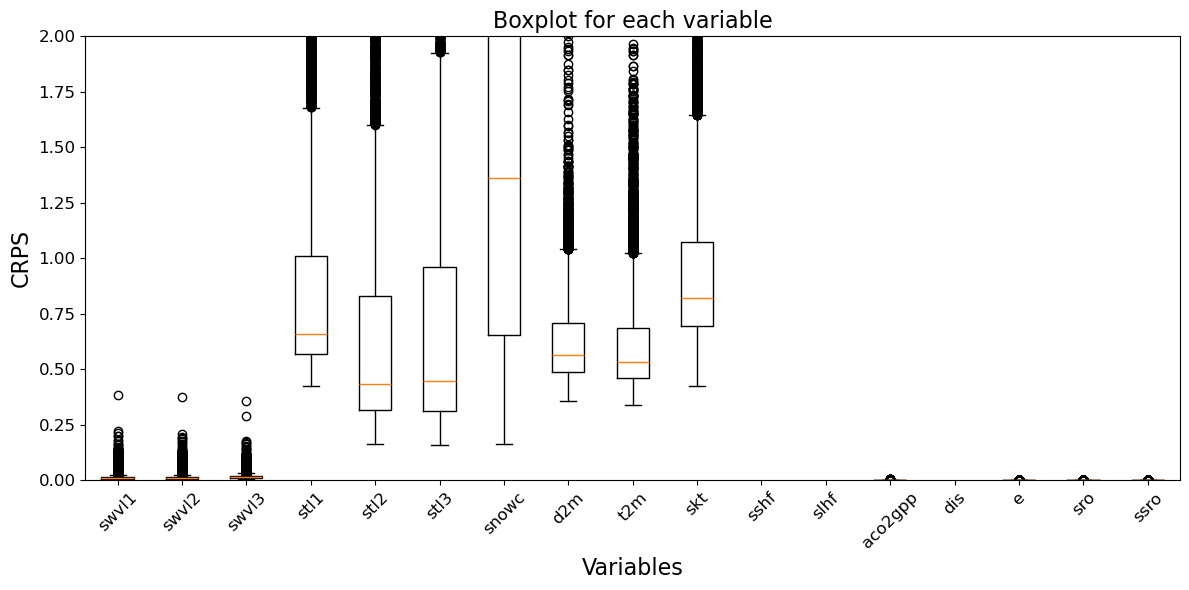

In [51]:
# visualize the crpss and crps in boxplot for all the variables -- the boxplot is representing the stack of the grid points
# The necessity to have the normalized crps or crpss -- since crps is related to the original magnitude of the variable itself

crps=xr.open_zarr("/data/ch23/evalution_results/uncertainty/crps_unimp_test_dask.zarr")
data = crps.crps.data  # This will be a numpy array of shape (10051, 17)
variables = crps.crps.coords['variable'].values  # Variable names

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
data_transposed = data.T
# Create a boxplot for each variable
ax.boxplot(data_transposed, labels=variables)

# Customize the plot
ax.set_title('Boxplot for each variable', fontsize=16)
ax.set_xlabel('Variables', fontsize=16)
ax.set_ylabel('CRPS', fontsize=16)
ax.set_ylim([0, 2])
plt.xticks(rotation=45, fontsize=12)  # Rotate variable names for better readability
plt.yticks(fontsize=12) 
plt.tight_layout()

# Show the plot
plt.show()


### plot CRPS for one variable but for whole period of inference time, as well as the confidence interval of the score

In [7]:
# the confidence interval comes from 10051 grid points

# choose one variable, showing the time series -- probably one part of the time series
# this can be plotted for all grid points, showing the confidence interval, but only one variable each time

crps_score_time_series = crps_dask(y_true[:,:,:17], y_pred[:,:,:,:17], time=False, sample_weight=None, norm=False)



In [8]:
# calculate the time series and uncertainty level of crps over all the grid points
# choose swvl1 as the example for plotting the time series
data=crps_score_time_series[:,:,0] # choose swvl1
data=data.T
mean = da.mean(data, axis=0)
std = da.std(data, axis=0)
confidence_interval = 1.96 * std / da.sqrt(data.shape[0])
# Generate datetime index
date_range = pd.date_range(start='2020-01-01 00:00:00', end='2022-11-30 18:00:00', periods=4260)


In [9]:
# visualization

plt.figure(figsize=(10, 6))

# Plot each realization
#for i in range(data.shape[0]):
#    plt.plot(date_range,data[i], color='gray', alpha=0.1)

# Plot the mean time series
plt.plot(date_range,mean, color='blue', label='Mean', linewidth=0.2)

# Shade the confidence interval
plt.fill_between(date_range, mean - confidence_interval, mean + confidence_interval, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('swvl1', fontsize=14)
plt.title('CRPS time seires of swvl1 over all grid cells', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(pd.Timestamp('2020-01-01 00:00:00'), pd.Timestamp('2022-11-30 18:00:00'))
plt.ylim(0,0.04)
plt.gcf().autofmt_xdate()
plt.show()

#### Characteristics of a good ensemble
Forecasts from a good ensemble should: 

display no mean errors (bias); otherwise the probabilities will be biased as well.
exhibit sharpness (i.e. have relatively small spread where the uncertainty is small).
have the ability to span the full climatological range; otherwise the probabilities will either over- or under-forecast the risks of anomalous or extreme weather events.

https://confluence.ecmwf.int/display/FUG/Section+5+Forecast+Ensemble+%28ENS%29+-+Rationale+and+Construction

#### Reasoning of not estimate aleatoric uncertainty in the training data, and we also do not consider structural uncertainty -- only parametric uncertainty, a type of epistemic uncertainty